# Compilamos el código de C++

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 10.1.0
-- The CXX compiler identification is GNU 10.1.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/fyulita/.virtualenvs/scienv/bin/python (found version "3.8.3") 
-- Found PythonLibs: /usr/lib/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/fyulita/Documents/UBA/2020-1C/Metodos Numericos/Material/Laboratorio/tp02
-

In [2]:
!pwd
!python --version
import metnum

/home/fyulita/Documents/UBA/2020-1C/Metodos Numericos/Material/Laboratorio/tp02/notebooks
Python 3.8.3


# Testeamos el cálculo de autovalores y autovectores

In [3]:
import numpy as np

In [4]:
A = np.array([
    [2, 0],
    [0, 1]
])
lambdas_exp = np.linalg.eig(A)[0]

lambdas, V = metnum.get_first_eigenvalues(A, 2)

assert np.allclose(lambdas_exp, lambdas)
assert np.allclose(V @ np.diag(lambdas) @ V.T, A)

In [5]:
B = np.array([
    [2, 1],
    [1, 1]
])
lambdas_exp = np.linalg.eig(B)[0]

lambdas, V = metnum.get_first_eigenvalues(B, 2)

assert np.allclose(lambdas_exp, lambdas)
assert np.allclose(V @ np.diag(lambdas) @ V.T, B)

In [6]:
C = np.random.rand(100, 100) # Creo una matriz al azar de 100x100 con coeficientes entre 0 y 100.
C = C @ C.T # La multiplico por sí misma transpuesta para que sea simétrica.
lambdas_exp = np.linalg.eig(C)[0]

lambdas, V = metnum.get_first_eigenvalues(C, 30) # Veamos los primeros valores, ya que esto es lo que vamos a hacer en PCA.

for i in range(len(lambdas)):
    if not np.isclose(lambdas_exp[i], lambdas[i]):
        print((lambdas_exp[i], lambdas[i]))

assert np.allclose(lambdas_exp[:30], lambdas)

(25.870364673564815, 26.073336080726197)
(26.073336080726197, 25.870364673564797)
(21.809331149904615, 22.00907701424178)
(22.009077014241768, 21.809331149904644)
(16.895651275780526, 16.923991873209083)
(16.92399187351525, 16.895651276087285)


AssertionError: 

#### Corrimos esta última celda varias veces y casi siempre tiró un error, pero viendo los autovalores que difieren uno se da cuenta de que no difieren por tanto. Si incrementamos los autovalores calculados de 30 a 100 entonces vemos que los últimos autovalores si difieren significativamente. Veamos de dónde provienen estos errores.

#### Primero veamos de cambiar la cantidad máxima de iteraciones. (Las celdas tardan un ratito en ejecutarse)

In [7]:
C = np.random.rand(100, 100) # Creo una matriz al azar de 100x100 con coeficientes entre 0 y 100.
C = C @ C.T # La multiplico por sí misma transpuesta para que sea simétrica.
lambdas_exp = np.linalg.eig(C)[0]

In [8]:
iters = np.linspace(5000, 1000000, 1000)

maxErrors = []
numErrors = []
for it in iters:
    lambdas, _ = metnum.get_first_eigenvalues(C, 30, num_iter=int(it))
    
    count = 0
    for i in range(len(lambdas)):
        if not np.isclose(lambdas_exp[i], lambdas[i]):
            count += 1
    
    maxErrors.append(np.max(np.abs(lambdas - lambdas_exp[:30])))
    numErrors.append(count)
maxErrors = np.asarray(maxErrors)
numErrors = np.asarray(numErrors)

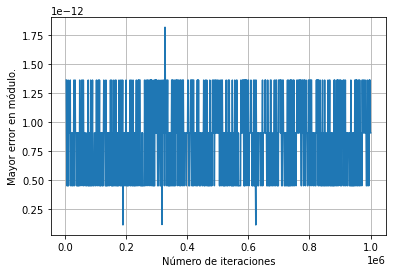

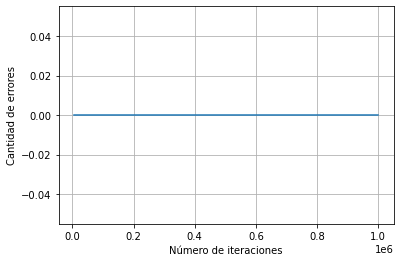

In [9]:
import matplotlib.pyplot as plt

plt.figure('maxErrors-Iter')
plt.plot(iters, maxErrors)
plt.xlabel('Número de iteraciones')
plt.ylabel('Mayor error en módulo.')
plt.grid()
plt.show()

plt.figure('numErrors-Iter')
plt.plot(iters, numErrors)
plt.xlabel('Número de iteraciones')
plt.ylabel('Cantidad de errores')
plt.grid()
plt.show()

#### Ahora veamos de cambiar el error mínimo permitido.

In [10]:
errors = np.linspace(1e-15, 1e-17, 1000)

maxErrors = []
numErrors = []
for err in errors:
    lambdas, _ = metnum.get_first_eigenvalues(C, 30, epsilon=err)
    
    count = 0
    for i in range(len(lambdas)):
        if not np.isclose(lambdas_exp[i], lambdas[i]):
            count += 1
    
    maxErrors.append(np.max(np.abs(lambdas - lambdas_exp[:30])))
    numErrors.append(count)
maxErrors = np.asarray(maxErrors)
numErrors = np.asarray(numErrors)

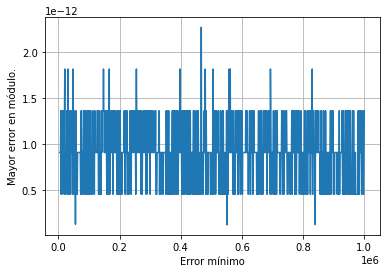

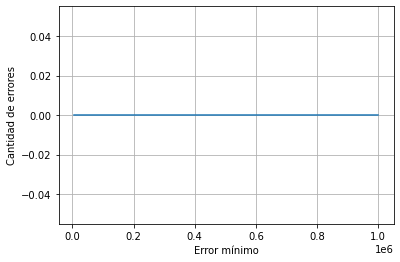

In [11]:
plt.figure('maxErrors-Err')
plt.plot(iters, maxErrors)
plt.xlabel('Error mínimo')
plt.ylabel('Mayor error en módulo.')
plt.grid()
plt.show()

plt.figure('numErrors-Err')
plt.plot(iters, numErrors)
plt.xlabel('Error mínimo')
plt.ylabel('Cantidad de errores')
plt.grid()
plt.show()

#### Como los gráficos son todos práctimente constantes esto refleja que el error proviene de la implementación o del algortimo. Ya que confiamos en la correctitud de la implementación y debido a que cada tanto para algunas matrices no hay errores, atribuimos los errores al algoritmo.

# Testeamos PCA

## Cálculo de Covarianza

*Para estos tests hace falta incluir la función "covariance" en la parte pública de PCA y agregarla a metnum.cpp.*

In [12]:
import numpy as np

alpha = 30

In [13]:
pca_A = metnum.PCA(alpha)
A = np.array([
    [64, 580, 29],
    [66, 570, 33],
    [68, 590, 37],
    [69, 660, 46],
    [73, 600, 55]
])
covariance_exp = np.cov(A.T)

covariance = pca_A.covariance(A)

assert np.allclose(covariance_exp, covariance)

In [14]:
pca_B = metnum.PCA(alpha)
B = np.array([
    [90, 60, 90],
    [90, 90, 30],
    [60, 60, 60],
    [60, 60, 90],
    [30, 30, 30]
])
covariance_exp = covariance_exp = np.cov(B.T)

covariance = pca_B.covariance(B)

assert np.allclose(covariance_exp, covariance)

In [15]:
pca_C = metnum.PCA(alpha)
C = np.random.rand(100, 20) # Creo una matriz al azar de 100x100 con coeficientes entre 0 y 100.
covariance_exp = covariance_exp = np.cov(C.T)

covariance = pca_B.covariance(C)

assert np.allclose(covariance_exp, covariance)